In [55]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")

In [56]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

In [57]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Preproc

In [58]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')

In [59]:
df['is_valid'] = False
df_test['is_valid'] = True
df_all = pd.concat([df, df_test])

In [60]:
clean_text(df_test)
clean_text(df)
clean_text(df_all)

<ipython-input-58-758c5916f40e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-58-758c5916f40e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


### Results
#### Train set results

In [73]:
dls_lm = TextDataLoaders.from_df(df_all, is_lm=True, valid_pct=0.1, text_col='text')
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()
learn_lm.load_encoder('min_finetuned_enc')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.encoder.weight", "0.encoder_dp.emb.weight", "0.rnns.0.weight_hh_l0_raw", "0.rnns.0.module.weight_ih_l0", "0.rnns.0.module.bias_ih_l0", "0.rnns.0.module.bias_hh_l0", "0.rnns.1.weight_hh_l0_raw", "0.rnns.1.module.weight_ih_l0", "0.rnns.1.module.bias_ih_l0", "0.rnns.1.module.bias_hh_l0", "0.rnns.2.weight_hh_l0_raw", "0.rnns.2.module.weight_ih_l0", "0.rnns.2.module.bias_ih_l0", "0.rnns.2.module.bias_hh_l0", "1.decoder.weight", "1.decoder.bias". 
	Unexpected key(s) in state_dict: "encoder.weight", "encoder_dp.emb.weight", "rnns.0.weight_hh_l0_raw", "rnns.0.module.weight_ih_l0", "rnns.0.module.bias_ih_l0", "rnns.0.module.bias_hh_l0", "rnns.1.weight_hh_l0_raw", "rnns.1.module.weight_ih_l0", "rnns.1.module.bias_ih_l0", "rnns.1.module.bias_hh_l0", "rnns.2.weight_hh_l0_raw", "rnns.2.module.weight_ih_l0", "rnns.2.module.bias_ih_l0", "rnns.2.module.bias_hh_l0". 

In [62]:
dls_clas = TextDataLoaders.from_df(df_all, valid_pct=0.4, text_col='text', label_col="sentiment")#, text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [63]:
def get_train_accuracy(modelName):
    return "Test Set Accuracy: ",learn.load_encoder(modelName).validate()[1]

In [64]:
print("Minimal: ",get_train_accuracy("min_finished")) #0.712

Minimal:  ('Test Set Accuracy: ', 0.31668758392333984)


#### Best confusion matrix

In [65]:
def draw_conf(learn):
    interp = ClassificationInterpretation.from_learner(learn)
    losses, idxs = interp.top_losses()
    len(dls_clas.valid_ds)==len(losses)==len(idxs)
    interp.plot_confusion_matrix(figsize=(7,7))

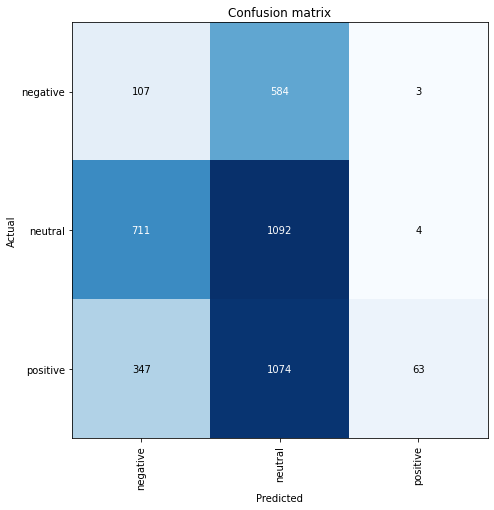

In [66]:
draw_conf(learn.load_encoder("min_finished"))

#### Test set results

In [67]:
def my_accuracy(y_pred, y_true):
    equ = [1 if i == t else 0 for i, t in zip(y_pred, y_true)]
    return np.mean(equ)

In [68]:
def get_train_accuracy(modelName):
    learner = learn.load_encoder(modelName)
    dl_test = learner.dls.test_dl(df_test, with_labels=True, drop_last=False)
    preds = learner.get_preds(dl=dl_test, with_decoded=True)
    predictions = preds[2]
    targets = preds[1]
    return my_accuracy(predictions, targets)

In [69]:
print("Test Set Accuracy - 'Minimal': ", get_train_accuracy('min_finished')) #0.723

Test Set Accuracy - 'Minimal':  0.305978898007034


In [70]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(targets, predictions)

In [71]:
#Tried cleaning up data: via function clean_text, didn't improve a thing :(

In [72]:
#>>Done>> #Try other model instead of AWD_LSTM > AWD_QRNN. Didnt work. Pytorch error, too complicated fix.: https://forums.fast.ai/t/cant-import-qrnn-or-qrnnlayer/45072/7
#>>Done>> #Try make test set as validation set in classifier.
#>>DONE>> Conclusion: Use test as valid. #See test accuracy change, after proper acc calc now, afte rreverting previous step
#>>DONE>> check the other dataset for LM, not Reuters titles but perhaps better data for LM there
#>>DONE>> #Bloomberg better. But data needs stripping down:
#>>DONE>> #-first rows untill www.bloomberg.com
#>>DONE>> #-last trows from . "To contact the reporters" or/and "NOTE 1:"
#>>DONE>> #Split classifier and language model into separate notebooks
#Try without cleaning
#Run the same cleaner preproccessing functions in LM as in train/test data for classifiers.
#Add preproccesing / cleaner functions into the pipeline?